In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import parent

In [2]:
import networks


In [3]:
import data

In [21]:
d1, d2 = data.get_dataset_triangles(
    "train", data_size=28, hollow=True
)

In [22]:
image_A, image_B = (x[0].cuda() for x in next(zip(d1, d2)))

In [11]:
import torch
from torch import nn
import numpy as np
from mermaidlite import compute_warped_image_multiNC, identity_map_multiN

import torch.nn.functional as F

class DenseMatrixNet(nn.Module):
    def __init__(self, size=28, dimension=2):
        super(DenseMatrixNet, self).__init__()
        self.dimension=dimension
        self.size=size
        self.dense1 = nn.Linear(size *size  * 2, 800)
        self.dense2 = nn.Linear(800, 300)
        self.dense3 = nn.Linear(300, 6 if self.dimension == 2 else 12)
        torch.nn.init.zeros_(self.dense3.weight)

    def forward(self, x, y):
        x = torch.reshape(torch.cat([x, y], 1), (-1, 2 * self.size * self.size))
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        if self.dimension == 3:
            x = torch.reshape(x, (-1, 3, 4))
            x = torch.cat([x, torch.Tensor([[[0, 0, 0, 1]]]).cuda().expand(x.shape[0], -1, -1)], 1)
            x = x + torch.Tensor([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]]).cuda()
        elif self.dimension==2:
            x = torch.reshape(x, (-1, 2, 3))
            x = torch.cat([x, torch.Tensor([[[0, 0, 1]]]).cuda().expand(x.shape[0], -1, -1)], 1)
            x = x + torch.Tensor([[1, 0, 0], [0, 1, 0], [0, 0, 0]]).cuda()
        else:
            raise ArgumentError()
        return x

class ConvMatrixNet(nn.Module):
    def __init__(self, size=128, dimension=2):
        super(ConvMatrixNet)

class InverseConsistentAffineDeformableNet(nn.Module):
    def __init__(self, affine_network, network, lmbda, input_shape):
        super(InverseConsistentAffineDeformableNet, self).__init__()

        self.sz = np.array(input_shape)
        self.spacing = 1.0 / (self.sz[2::] - 1)

        _id = identity_map_multiN(self.sz, self.spacing)
        self.register_buffer("identityMap", torch.from_numpy(_id))
        
        _id_projective = np.concatenate([_id, np.ones(input_shape)], axis=1)
        self.register_buffer("identityMapProjective", torch.from_numpy(_id_projective).float())
        
        self.map_shape = self.identityMap.shape
        
        self.affine_regis_net = affine_network
        self.regis_net = network
        
        self.lmbda = lmbda

    def adjust_batch_size(self, BATCH_SIZE):
        self.sz[0] = BATCH_SIZE
        self.spacing = 1.0 / (self.sz[2::] - 1)

        _id = identity_map_multiN(self.sz, self.spacing)
        self.register_buffer("identityMap", torch.from_numpy(_id))
        
        _id_projective = np.concatenate([_id, np.ones(input_shape)], axis=1)
        self.register_buffer("identityMapProjective", torch.from_numpy(_id_projective).float())

    def forward(self, image_A, image_B):
        #Compute Displacement Maps
        
        batch_matrix_multiply = "ijkl,imj->imkl"
        self.matrix_AB = self.affine_regis_net(image_A, image_B)
        
        self.phi_AB_affine = torch.einsum(
            batch_matrix_multiply, self.identityMapProjective, self.matrix_AB)
        
        self.phi_AB_affine_inv = torch.einsum(
            batch_matrix_multiply, self.identityMapProjective, torch.inverse(self.matrix_AB))

        self.matrix_BA = self.affine_regis_net(image_B, image_A)
        
        self.phi_BA_affine = torch.einsum(
            batch_matrix_multiply, self.identityMapProjective, self.matrix_BA)
        
        self.phi_BA_affine_inv = torch.einsum(
            batch_matrix_multiply, self.identityMapProjective, torch.inverse(self.matrix_BA))
        
        #resample using affine for deformable step. Use inverse to get residue in correct coordinate space
        
        self.affine_warped_image_B = compute_warped_image_multiNC(
            image_B, self.phi_AB_affine_inv[:, :2], self.spacing, 1)
        
        self.affine_warped_image_A = compute_warped_image_multiNC(
            image_A, self.phi_BA_affine_inv[:, :2], self.spacing, 1)
        
        self.D_AB = nn.functional.pad(self.regis_net(image_A, self.affine_warped_image_B), (0, 0, 0, 0, 0, 1))
        self.phi_AB = self.phi_AB_affine + self.D_AB
        
        self.D_BA = nn.functional.pad(self.regis_net(image_B, self.affine_warped_image_A), (0, 0, 0, 0, 0, 1))
        self.phi_BA = self.phi_BA_affine + self.D_BA
              
        #Compute Image similarity
        
        self.warped_image_A = compute_warped_image_multiNC(
            image_A, self.phi_AB[:, :2], self.spacing, 1
        )

        self.warped_image_B = compute_warped_image_multiNC(
            image_B, self.phi_BA[:, :2], self.spacing, 1
        )

        similarity_loss = torch.mean((self.warped_image_A - image_B) ** 2) + torch.mean(
            (self.warped_image_B - image_A) ** 2
        )
        
        #Compute Inverse Consistency
        #One way

        self.approximate_zero = (
            torch.einsum(
                batch_matrix_multiply, self.phi_AB, self.matrix_BA)[:, :2] 
            + compute_warped_image_multiNC(self.D_BA[:, :2], self.phi_AB[:, :2], self.spacing, 1)
            - self.identityMap
        )
        self.approximate_zero2 = (
            torch.einsum(
                batch_matrix_multiply, self.phi_BA, self.matrix_AB)[:, :2] 
            + compute_warped_image_multiNC(self.D_AB[:, :2], self.phi_BA[:, :2], self.spacing, 1)
            - self.identityMap
        )
        inverse_consistency_loss = self.lmbda * torch.mean(
            (self.approximate_zero) ** 2 + (self.approximate_zero2)**2
        )
        transform_magnitude = self.lmbda * torch.mean(
            (self.identityMap - self.phi_AB[:, :2]) ** 2
        )
        self.all_loss = inverse_consistency_loss + similarity_loss
        return [
            x
            for x in (
                self.all_loss,
                inverse_consistency_loss,
                similarity_loss,
                transform_magnitude,
            )
        ]
class MapToFunctionNet(nn.Module):
    def __init__(self, network, input_shape):
        pass 

In [12]:
net = InverseConsistentAffineNet(DenseMatrixNet(), networks.tallUNet3(normalization="groupnorm"), 100, next(iter(d1))[0].size())
net.cuda()

/playpen-raid1/tgreer/InverseConsistency/networks.py:430: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([[2, 16, 32, 64, 256, 512], [16, 32, 64, 128, 256]]),


InverseConsistentAffineNet(
  (affine_regis_net): DenseMatrixNet(
    (dense1): Linear(in_features=1568, out_features=800, bias=True)
    (dense2): Linear(in_features=800, out_features=300, bias=True)
    (dense3): Linear(in_features=300, out_features=6, bias=True)
  )
  (regis_net): UNet3(
    (downConvs): ModuleList(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (upConvs): ModuleList(
      (0): ConvTranspose2d(48, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ConvTranspose2d(96, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (2): ConvTranspose2d(192, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


In [13]:
net.affine_regis_net.load_state_dict(torch.load("../network_weights/hollow_shape_28_affinenet.trch"))

<All keys matched successfully>

In [14]:
qq = net(image_A, image_B)

In [26]:
import train

In [27]:
optim = torch.optim.Adam(net.parameters(), lr=.0001)
net.train().cuda()

InverseConsistentAffineNet(
  (affine_regis_net): DenseMatrixNet(
    (dense1): Linear(in_features=1568, out_features=800, bias=True)
    (dense2): Linear(in_features=800, out_features=300, bias=True)
    (dense3): Linear(in_features=300, out_features=6, bias=True)
  )
  (regis_net): UNet3(
    (downConvs): ModuleList(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (upConvs): ModuleList(
      (0): ConvTranspose2d(48, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ConvTranspose2d(96, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (2): ConvTranspose2d(192, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


In [42]:
x = train.train2d(net, optim, d1, d2, epochs=350)

[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[------

KeyboardInterrupt: 

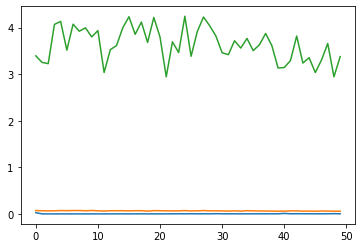

In [29]:
import matplotlib.pyplot as plt
plt.plot(np.array(x)[:, :3])

In [30]:
import visualize

RuntimeError: grid_sampler(): expected grid to have size 2 in last dimension, but got grid with sizes [128, 28, 28, 3]

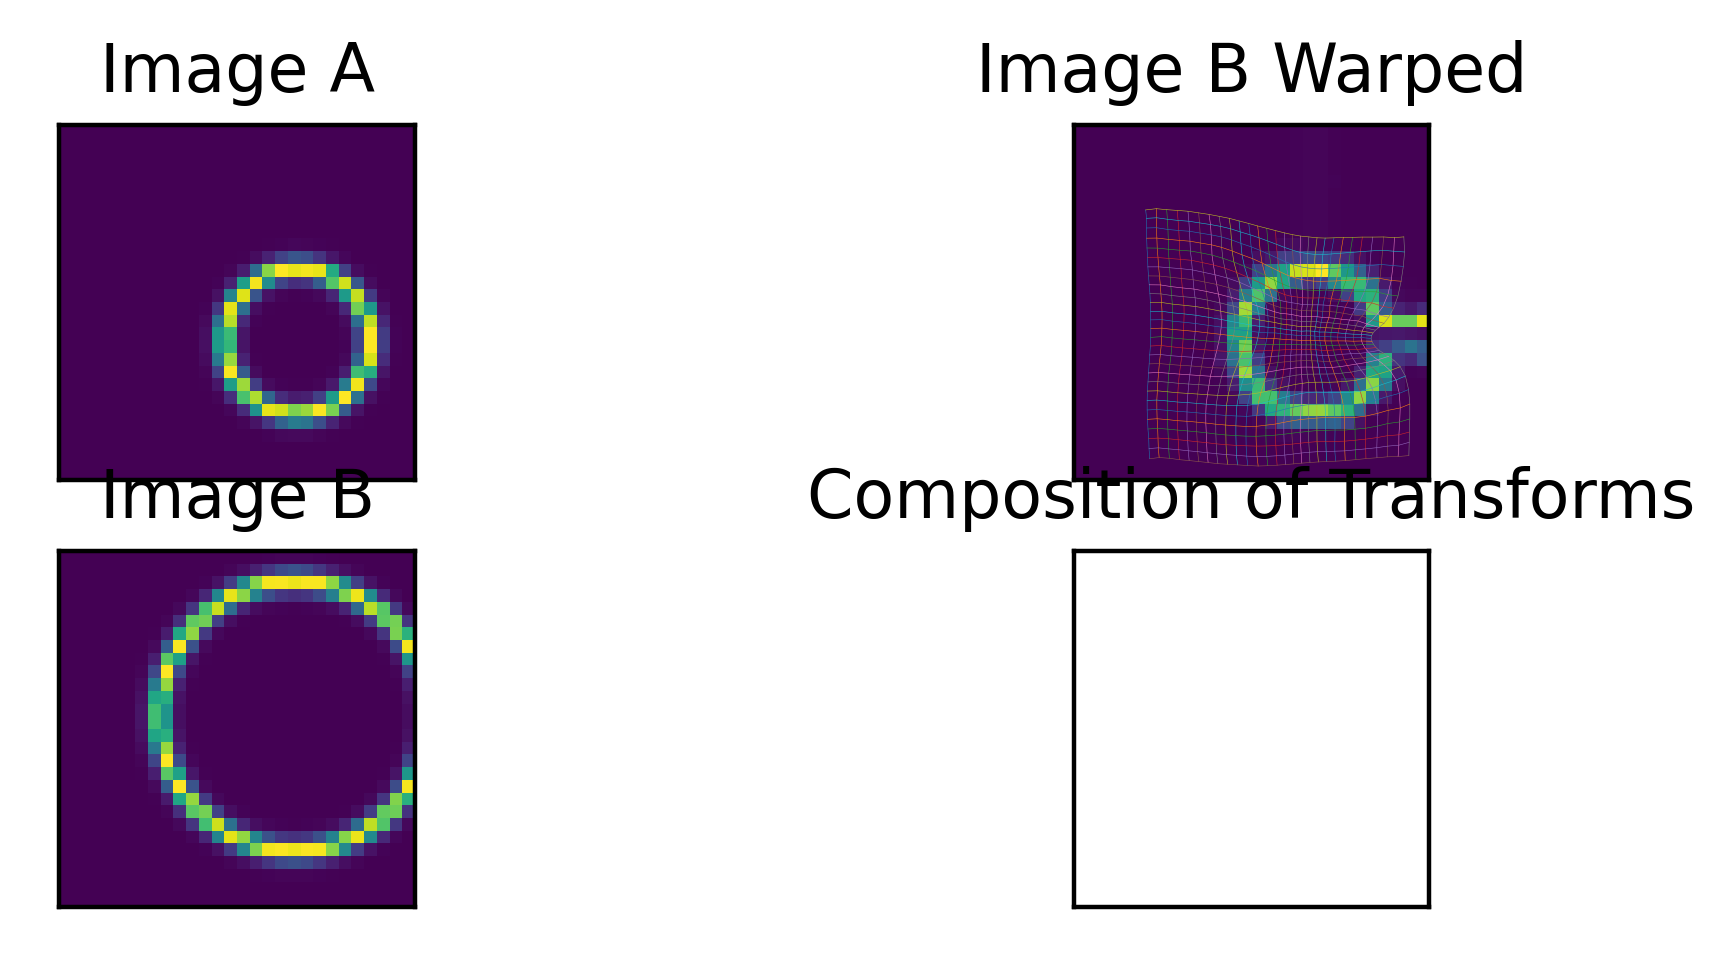

In [49]:
if not "N" in locals():
    N = 0
N += 1
visualize.visualizeRegistration(net, image_A, image_B, N, False)


In [85]:
net.matrix_AB[2] @net.matrix_BA[2]

tensor([[ 1.0765,  0.0030, -0.0415],
        [-0.0240,  1.0611, -0.0310],
        [ 0.0000,  0.0000,  1.0000]], device='cuda:0', grad_fn=<MmBackward>)

In [86]:
np.matrix(net.matrix_BA[N].cpu().detach().numpy())**-1

matrix([[ 1.2013184 , -0.00423829, -0.04185517],
        [-0.00410884,  1.2154729 , -0.01405132],
        [ 0.        ,  0.        ,  1.        ]], dtype=float32)

In [87]:
batch_matrix_multiply = "ijkl,imj->imkl"

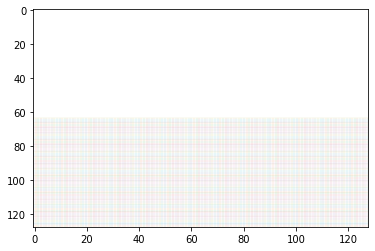

In [88]:
pp = torch.einsum(
    batch_matrix_multiply, 
    net.identityMapProjective[:1], 
    torch.Tensor([[[1, 0, .5], [0, 1, 0], [0, 0, 1]]]).cuda())[0]
visualize.show_as_grid(pp)

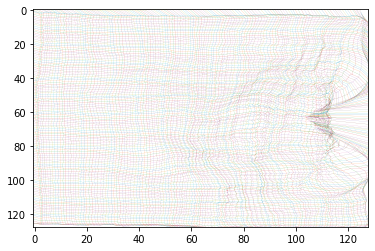

In [89]:
visualize.show_as_grid(compute_warped_image_multiNC(net.phi_AB[:, :2], net.phi_BA[:, :2], net.spacing, 1)[N])

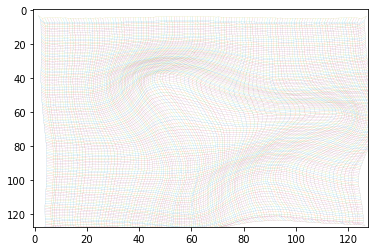

In [90]:
visualize.show_as_grid(net.D_AB[0, :2] + net.identityMap[0])

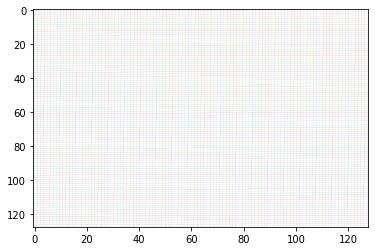

In [99]:
visualize.show_as_grid(net.phi_BA_affine_inv[N])

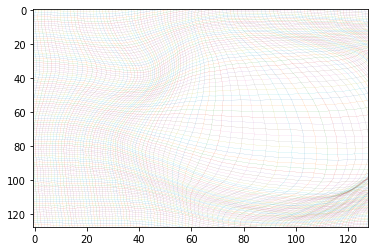

In [97]:
visualize.show_as_grid(net.phi_AB[N])